# 1. Bayesian optimization (BO)

Content
1. Bayesian optimization overview
2. One dimensional example
3. AutoML: optimization of hyperparameters for machine learning model

# When Bayesian optimization?

* Optimization of "heavy" functions 
* The target function is a blackbox, typically noisy, while smooth


* Construction a regression model using available data
* Take into account uncertainty of the regression model
* Gaussian process regression is OK

## Frameworks

We need libraries for
* Gaussian process regression **[GPyTorch](https://gpytorch.ai/)** (see previous seminar)
* Gaussian process regression-based Bayesian optimization **[BoTorch](https://botorch.org/)**

Uncomment and run the following celll to install BoTorch

In [1]:
# !pip install botorch

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# auxiliary functions
import utils

import tqdm

# One dimensional example

We demonstrate concepts using one-dimensional example.

Let us consider Bayesian optimization for one-dimensional function **Forrester**:
$$
f(x) = (6 x - 2)^2 \sin(12 x - 4).
$$

The optimization problem is the following:
$$
f(x) \rightarrow \min, x \in [0, 1].
$$

In [3]:
import torch

torch.manual_seed(0)

device = 'cpu'
dtype = torch.float64

In [4]:
def forrester(x):
    """
    Forrester function
        
        y = (6x - 2)^2 \sin(12x - 4), x \in [0, 1]
    
    Parameters
    ----------
    x : torch.tensor, shape=(n_samples,)
        Input values
    
    Returns
    -------
    y : torch.tensor
        Output values
    """
    y = (6 * x - 2)**2 * torch.sin(12 * x - 4)
    return y

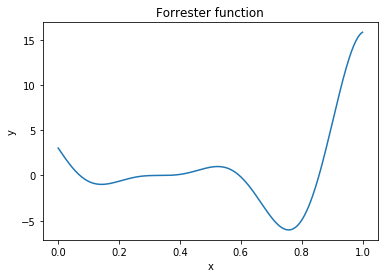

In [5]:
x = np.linspace(0, 1, 300)
plt.plot(x, forrester(torch.tensor(x)).numpy())
plt.xlabel('x')
plt.ylabel('y')
plt.title('Forrester function');

# Optimization workflow:
1. Construct a regression model $\hat{f}(x)$ of a function $f(x)$ using the sample $D = \{(x_i, f(x_i))\}_{i = 1}^n$
2. Select a new point that maximize an acquisition function
$$
x_{new} = \arg\max\limits_x a(x)
$$
3. Calculate $f(x_{new})$ at the new point.
4. Add the pair $(x_{new}, f(x_{new}))$ to the sample $D$.
5. Update the model $\hat{f}(x)$ and go to step 2.

## We have a black-box objective function. Now we define components needed for BO

1. What kind of the regression model we need
2. What kind of the acquisition function we use
3. How do we optimize the acquisition function
4. Should we use sequential or batch optimization?

## 0. Let's create initial design and plot it

In [6]:
def generate_initial_data(n=10):
    X = torch.rand(n, 1, device=device, dtype=dtype)
    y = forrester(X)
    return X, y

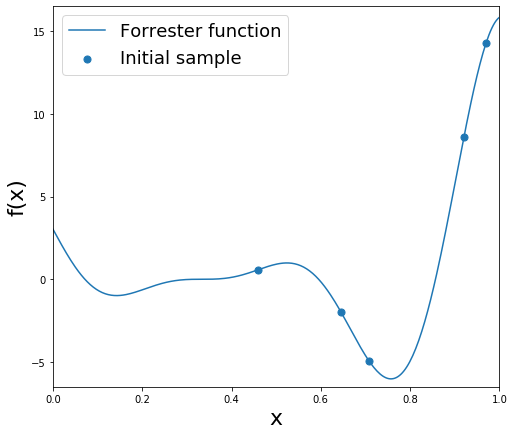

In [7]:
X, y = generate_initial_data(n=5)
utils.plot_1D_function(forrester, X)

## 1. Create GP model and fit it using initial design

For BO we need a model that return a probability distribution for each point X.  
The most widely used model is Gaussian Processes based models.

In [8]:
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model


def initialize_model(X, y, GP=None, state_dict=None, *GP_args, **GP_kwargs):
    """
    Create GP model and fit it. The function also accepts
    state_dict which is used as an initialization for the GP model.
    
    Parameters
    ----------
    X : torch.tensor, shape=(n_samples, dim)
        Input values
        
    y : torch.tensor, shape=(n_samples,)
        Output values
        
    GP : botorch.models.Model
        GP model class
        
    state_dict : dict
        GP model state dict
        
    Returns
    -------
    mll : gpytorch.mlls.MarginalLoglikelihood
        Marginal loglikelihood
    
    gp : 
    """

    if GP is None:
        GP = SingleTaskGP
        
    model = GP(X, y, *GP_args, **GP_kwargs).to(X)

    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return mll, model

In [9]:
mll, gp = initialize_model(X, y)
fit_gpytorch_model(mll);

## 2. Create acquisition function

### Examples of the acquisation functions 

#### Upper confidence bound (UCB) 

$$
UСB(x) = \hat{f}(x) + \beta \hat{\sigma}(x),
$$
$\hat{f}(x), \hat{\sigma}(x)$ - mean and standard deviation of the Gaussian process regression model at $x$.

#### Probability of Improvement (PI)

$$
PI(x) = P \left ( \hat{f}(x) < f_{min} \right )
$$

#### Expected Improvement (EI) 

$$
EI(x) = \mathbb{E}_{p(\hat{f})} (f_{min} - \hat{f}(x))_+.
$$

In [10]:
from botorch.acquisition import ExpectedImprovement

acquisition = ExpectedImprovement(gp, y.min(), maximize=False)

## 3. Optimize acquisition function to obtain new candidate points

In [11]:
from botorch.optim import joint_optimize, sequential_optimize

bounds = torch.tensor([[0], [1]]).to(X)
candidate = joint_optimize(
    acquisition, bounds=bounds, q=10, num_restarts=5, raw_samples=1000,
)

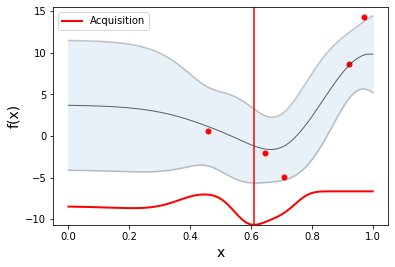

In [12]:
utils.plot_acquisition(acquisition, X, y, candidate)

## 4. Update the data set

In [13]:
# Update data set
X = torch.cat([X, candidate])
y = torch.cat([y, forrester(candidate)])

## 5. Update the GP model

In [14]:
# Update GP model
mll, gp = initialize_model(X, y, state_dict=gp.state_dict())
fit_gpytorch_model(mll);

## 6. Repeat from step 1

**Task** implement `bo_step()` function below. Steps:
1. Create and fit GP model using given `X, y, GP` (`GP` is a model constructor that takes as input pair `X` and `y`)
2. Create acquisition function using constructed model and `acquisition` (this is an acquisiton function constructor that takes as input gp model)
3. Optimize acquisition function to find new `candidate`
4. Update `X, y` by appending to `candidate`
5. Return updated `X, y` and the GP model

In [15]:
def bo_step(X, y, objective, bounds, GP=None, acquisition=None, q=1, state_dict=None, plot=False):
    """
    One iteration of Bayesian optimization:
        1. Fit GP model using (X, y)
        2. Create acquisition function
        3. Optimize acquisition function to obtain candidate point
        4. Evaluate objective at candidate point
        5. Add new point to the data set
        
    Parameters
    ----------
    X : torch.tensor, shape=(n_samples, dim)
        Input values
        
    y : torch.tensor, shape=(n_samples,)
        Objective values
        
    objective : callable, argument=torch.tensor
        Objective black-box function, accepting as an argument torch.tensor
        
    bounds : torch.tensor, shape=(2, dim)
        Box-constraints
    
    GP : callable
        GP model class constructor. It is a function that takes as input
        2 tensors - X, y - and returns an instance of botorch.models.Model.
       
    acquisition : callable
        Acquisition function construction. It is a function that receives
        one argument - GP model - and returns an instance of
        botorch.acquisition.AcquisitionFunction
        
    q : int
        Number of candidate points to find
        
    state_dict : dict
        GP model state dict
        
    plot : bool
        Flag indicating whether to plot the result
        
    Returns
    -------
    X : torch.tensor
        Tensor of input values with new point
        
    y : torch.tensor
        Tensor of output values with new point
        
    gp : botorch.models.Model
        Constructed GP model
    
        
    Example
    -------
    >>> from botorch.models import FixedNoiseGP
    >>> noise_var = 1e-2 * torch.ones_like(y)
    >>> GP = lambda X, y: FixedNoiseGP(X, y, noise_var)
    >>> acq_func = labmda gp: ExpectedImprovement(gp, y.min(), maximize=False)
    >>> X, y = bo_step(X, y, objective, GP=GP, Acquisition=acq_func)
    
    """
    
    ### Your code goes here ###
    
    # Create GP model
    mll, gp = initialize_model(X, y, GP=GP, state_dict=state_dict)
    fit_gpytorch_model(mll)
    
    # Create acquisition function
    acquisition = acquisition(gp)
    
    # Optimize acquisition function
    candidate = joint_optimize(
        acquisition, bounds=bounds, q=q, num_restarts=5, raw_samples=1000,
    )
    
    # Update data set
    X = torch.cat([X, candidate])
    y = torch.cat([y, objective(candidate)])
    
    ### Your code ends here ###
    
    if plot:
        utils.plot_acquisition(acquisition, X, y, candidate)
        
    return X, y, gp

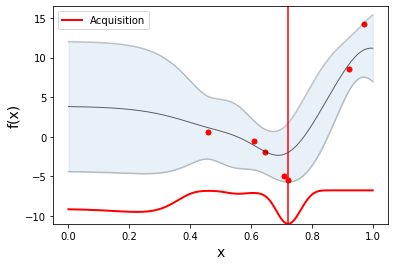

In [16]:
objective = forrester
bounds = torch.tensor([[0], [1]], dtype=dtype)
acquisition = lambda gp: ExpectedImprovement(gp, y.min(), maximize=False)

X, y, gp = bo_step(X, y, forrester, bounds, GP=None,
                   acquisition=acquisition, plot=True,
                   state_dict=gp.state_dict())

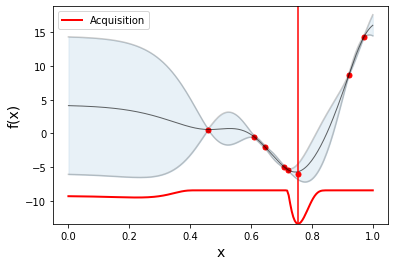

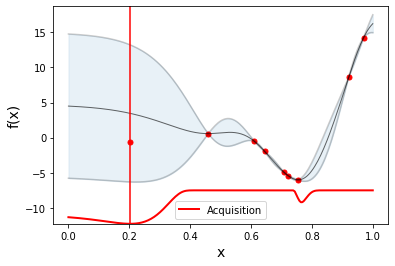

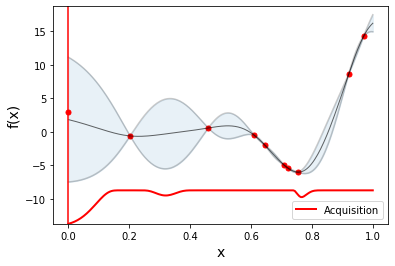

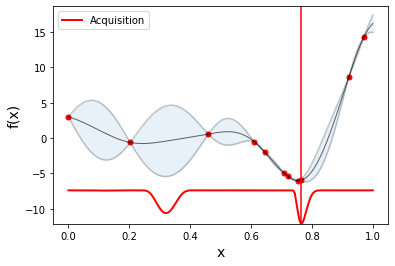

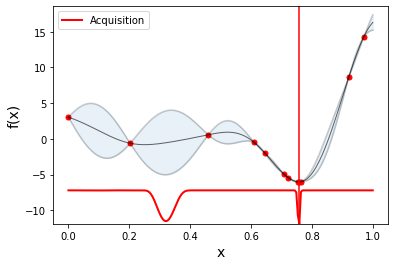

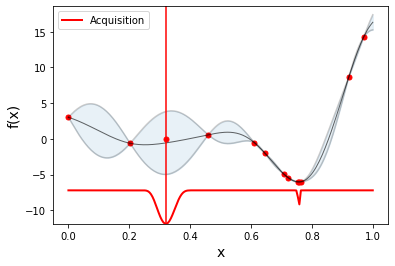

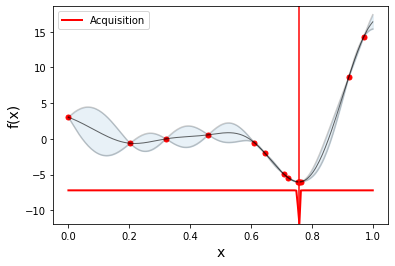

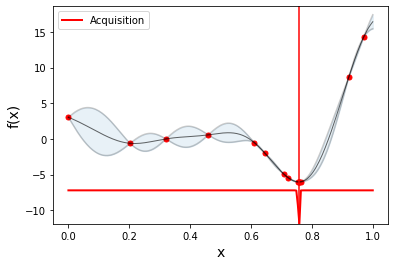

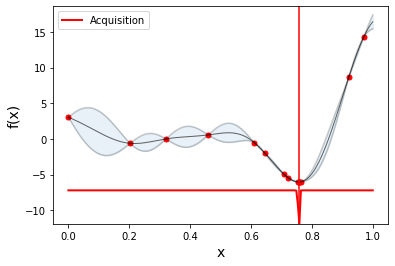

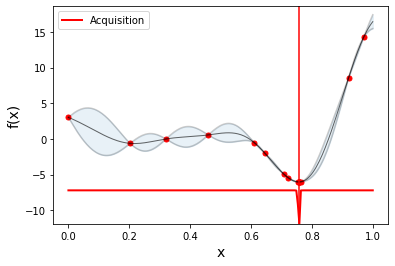

In [17]:
for _ in range(10):
    acquisition = lambda gp: ExpectedImprovement(gp, y.min(),
                                                 maximize=False)
    X, y, gp = bo_step(X, y, forrester, bounds, GP=SingleTaskGP,
                       acquisition=acquisition, plot=True,
                       state_dict=gp.state_dict())

## Analyze results

Two criteria
1. Distance between consecutive x's
2. Current best value of the objective

In [18]:
%load_ext autoreload
%autoreload 2

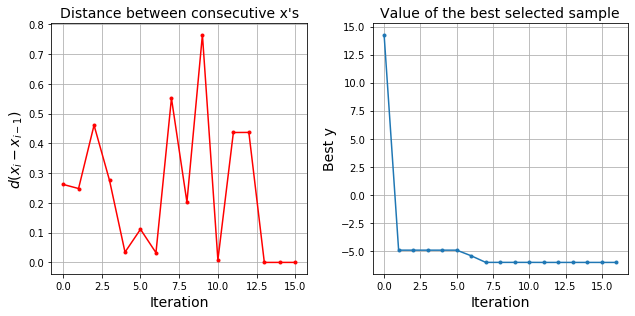

In [19]:
utils.plot_convergence(X, y)

In [20]:
print(f'Obtained xmin:  {X[-1].item():.3f}, real xmin: 0.780 (approximate)')
print(f'Obtained fmin: {y[-1].item():.3f}, real fmin: -6.000 (approximate)')

Obtained xmin:  0.757, real xmin: 0.780 (approximate)
Obtained fmin: -6.021, real fmin: -6.000 (approximate)


## Lower Confidence Bound (LCB) acquisition function
Upper Confidence Bound (UCB) is for maximization. LCB
$$
    LCB(x) = \hat{f}(x) - \beta \hat{\sigma}(x)
$$
is for minimization.

**Question**: Should we maximize or minimize the LCB?

In [21]:
from botorch.acquisition import UpperConfidenceBound

class LowerConfidenceBound(UpperConfidenceBound):
    def __init__(self, gp, beta):
        # When maximize==True UCB returns (\mu - beta * \sigma)
        # though it is still maximized
        super().__init__(gp, beta, maximize=False)
        
    def forward(self, X):
        # The criterion is maximized, so we flip the sign
        # to find argmin
        lcb = super().forward(X)
        return -lcb

## Task

Optimize forrester function using LCB acquisition function.  
What happens if $\beta$ is small? Large?

In [22]:
X, y = generate_initial_data(n=5)

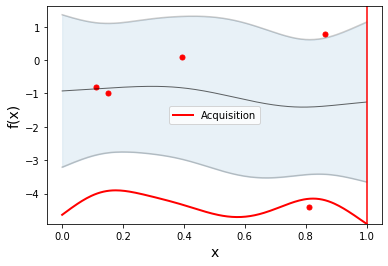

In [23]:
acquisition = lambda gp: LowerConfidenceBound(gp, beta=1000)
X, y, gp = bo_step(X, y, forrester, bounds,
                   acquisition=acquisition,
                   plot=True)

# 3. Bayesian optimization for the parameters of Gradient boosting

Now we optimize hyperparameters for Gradient boosting of decision trees.

In [24]:
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

If lightgbm is not installed, please run the following cell

In [25]:
# !pip install lightgbm

### We predict defaults for the classification problem

The goal is to predict if the two years absense of payments occur.

In [26]:
# Load the training sample
data = pd.read_csv('training_data.csv')
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [27]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data['SeriousDlqin2yrs']

#### Define objective function

The objective function should take `torch.tensor`, convert it to a `list` of `dictionaries` with model parameters
and for each set of model parameters calculate cross-validation score of the model

Note, that we constrain the search space to [0, 1]-hypercube, but inside the objective function rescale the parameters
to the correct bounds.
We do this to obtain better GP models.

In [28]:
import lightgbm as lgb
from botorch.utils.transforms import normalize, unnormalize

from joblib import Parallel, delayed


def wrap_X(X, space):
    """
    Wrap tensor to a list of dictionaries
    
    Parameters:
    X : torch.tensor, shape=(n_samples, dim)
        Tensor of parameters values
        
    space : dict
        Search space description
        
    Returns
    -------
    wrapped_X : lsit[dict{param_name: value}]
        List of dictionary of parameters
    """
    def _wrap_row(row):
        wrapped_row = {}
        for i, x in enumerate(row):
            wrapped_row[space[i]['name']] = x.item()
        
            if space[i]['type'] == 'discrete':
                wrapped_row[space[i]['name']] = int(np.round(x.item()))
        return wrapped_row
    
    wrapped_X = []
    for i in range(X.shape[0]):
        wrapped_X.append(_wrap_row(X[i]))
        
    return wrapped_X


def unwrap_X(parameters, space):
    """
    Unwrap list of dictionaries to torch.tensor
    
    Parameters
    ----------
    parameters : list(dict)
        List of parameters
        
    space : dict
        Input space definition
        
    Returns
    -------
    unwrapped_X : torch.tensor
        Tensor of parameter values
    """
    X = torch.zeros(len(parameters), len(space),
                    dtype=torch.float64)
    for i, p in enumerate(parameters):
        x = [p[var['name']] for var in space]
        X[i] = torch.tensor(x, dtype=torch.float64)
        
    return X


def get_cv_quality(parameters, space):
    """
  
    Quality of model using given hyperparameters

    Parameters
    ----------
    parameters : torch.tensor, shape=(n_samples, dim)
        Tensor of hyperparameteres
        
    space : dict
        Input space description

    Returns
    -------
    roc_auc : torch.tensor
        Tensor of ROC AUC values
    """

    # Rescale to original bounds
    dtype = parameters.dtype
    device = parameters.device
    bounds = torch.tensor([var['domain'] for var in space]).to(parameters).t()
    parameters = unnormalize(parameters, bounds)

    # Convert tensor to a list of dictionaries
    parameters = wrap_X(parameters, space)
    
    def _get_score(params_dict):
        model = lgb.LGBMClassifier(**params_dict, n_jobs=-1)
        score = np.mean(cross_validate(model, X, y, cv=5, n_jobs=-1,
                                       scoring='roc_auc')['test_score'])
        return score
    
    score_list = Parallel(-1)(delayed(_get_score)(p) for p in parameters)

    return torch.tensor(score_list, dtype=dtype, device=device)

### Define the search space

For each parameter we defin
* type - "discrete" or "continuous"
* domain - box-constraints for the parameter

In [29]:
# Define the region
space = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.05, 0.2)},
    {'name': 'n_estimators', 'type': 'discrete', 'domain': (50, 300)},
    {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 30)},
    {'name': 'gamma', 'type': 'continuous', 'domain': (0,  5)},
    {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}
]

#### Task

Generate `5` initial points. Remember, they should be in `[0, 1]` interval

In [30]:
### Your code goes here ###

from botorch.utils.sampling import draw_sobol_samples

bounds_01 = torch.zeros(2, len(space), dtype=torch.float64)
bounds_01[1] = 1

init_X = draw_sobol_samples(bounds_01, 5, 1).squeeze()
init_y = get_cv_quality(init_X, space)

# q-Expected Improvement

In previous examples we conducted *sequential* optimization, i.e. we generated candidates sequentially one-by-one.  
However, we can generate $q$-candidates at a time.  
For this we need special acquisition function, e.g. batched version of Expected Improvement
$$
    {\rm qEI}(x) = \mathbb{E} \left ( \max_{i \in \{1, \ldots, q\}} ( f_{min} - \hat{f}(x_i)) \right )_+
$$

**Pros**
* Faster (in wall time) if objective function evaluation can be parallelized
* Small $q$ values (~5) gives the same performance as sequential optimization

**Cons**
* Large $q$ suffers from harder optimization problem
* $q$-acquisition functions are intractable, we need to use approximations. In BoTorch they are evaluated using (q-)MC sampling.

### Run Bayesian optimization

#### Task

Run bayesian optimization.
* Try to use sequential optimization (as we did in previous tasks)
* Try to apply $q$-ExpectedImprovement
    * use `botorch.acquisition.qExpectedImprovement`
    * pass `q` argument to `bo_step()` function
* What about performance of each of 2 approaches (you need to run several times and calculate mean and std)? Wall time?

In [31]:
%%time 

from botorch.acquisition import NoisyExpectedImprovement, qExpectedImprovement
from botorch.models import FixedNoiseGP


params = init_X
scores = init_y
state_dict = None

q = 5
budget = 100

objective = lambda x: get_cv_quality(x, space)

with tqdm.tqdm(total=budget) as bar:
    while len(scores) < budget:
        
        n_samples = len(scores)
    
        ### Your code goes here ###

        GP = SingleTaskGP
        
        acquisition = lambda gp: ExpectedImprovement(gp, scores.max())
#         acquisition = lambda gp: qExpectedImprovement(gp, scores.max())


        params, scores, gp = bo_step(params, scores, objective, bounds_01,
                                     GP=GP, acquisition=acquisition, q=q,
                                     state_dict=state_dict)
        state_dict = gp.state_dict()
        
        ### Your code ends here ###
        
        bar.update(len(scores) - n_samples)

 95%|█████████▌| 95/100 [00:45<00:01,  2.65it/s]

CPU times: user 3min 3s, sys: 3min 32s, total: 6min 35s
Wall time: 45.4 s


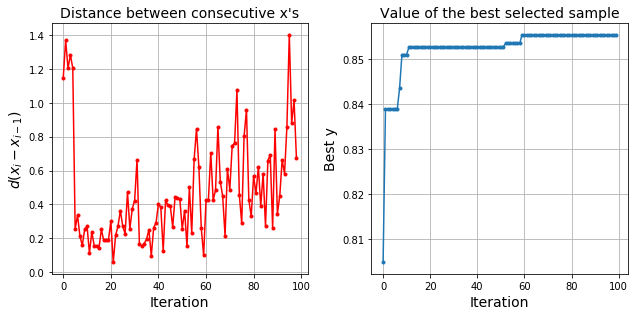

In [32]:
utils.plot_convergence(params, scores, maximize=True)

In [33]:
def get_best_params(params, scores, space):
    bounds = torch.tensor([var['domain'] for var in space]).to(params).t()
    params = unnormalize(params, bounds)
    
    best_idx = np.argmax(scores.cpu().numpy())
    return wrap_X(params[[best_idx]], space)[0]

## Validate parameters using a test sample

In [34]:
# Load the testing sample
test_data = pd.read_csv('test_data.csv')

X_test = test_data.drop('SeriousDlqin2yrs', axis=1)
y_test = test_data['SeriousDlqin2yrs']

#### Model with default parameters

In [35]:
initial_model = lgb.LGBMClassifier()
initial_model.fit(X, y)
proba_predicted = initial_model.predict_proba(X_test)[:, 1]
print(f"Default parameters: ROC AUC = {roc_auc_score(y_test, proba_predicted):.3f}")

Default parameters: ROC AUC = 0.803


#### Model with tuned parameters

In [36]:
best_param = get_best_params(params, scores, space)
best_model = lgb.LGBMClassifier(**best_param)
best_model.fit(X, y)
proba_predicted = best_model.predict_proba(X_test)[:, 1]
print(f"Optimized parameters: ROC AUC = {roc_auc_score(y_test, proba_predicted):.3f}")
print(f"Parameters: {best_param}")

Optimized parameters: ROC AUC = 0.836
Parameters: {'learning_rate': 0.05000000074505806, 'n_estimators': 50, 'max_depth': 3, 'gamma': 2.297512920128078, 'min_child_weight': 9}


# Tree Parzen Estimator (TPE)

Expected Improvement can be calculated without GP model

$$
p(y | x) \propto p(x | y) p(y)
$$

$$
p(x | y) = \begin{cases}
    l(x), \mbox{ if} y < y^* \\
    g(x), \mbox{ if} y \ge y^* \\
\end{cases},
$$
where $y^*$ is some quantile $\gamma$ of $y$, i.e., $p(y < y^*) = \gamma$.

$$
EI(x) \propto \left ( \gamma + \frac{g(x)}{l(x)}(1 - \gamma) \right )^{-1}
$$
$l(x)$ and $g(x)$ are estimated using KDE (kernel density estimate)

### Task: prove the expression for EI above

In [37]:
# !pip install --upgrade git+git://github.com/hyperopt/hyperopt.git

In [38]:
from hyperopt import fmin, hp, tpe

params_names = ['learning_rate', 'n_estimators', 'subsample']

space_hp = {
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
    'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
    'max_depth': hp.quniform('max_depth', 1, 30, 1),
    'gamma': hp.uniform('gamma', 0,  5),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
}

types = {
    'learning_rate': 'continuous',
    'n_estimators': 'discrete',
    'max_depth': 'discrete',
    'gamma': 'continuous',
    'min_child_weight': 'discrete'
}

random_state = np.random.RandomState()

def wrap_params(params, types):
    wrapped_params = params.copy()
    for key in wrapped_params:
        if types[key] == 'discrete':
            wrapped_params[key] = int(wrapped_params[key])

    return wrapped_params


best = fmin(lambda x: -get_cv_quality(unwrap_X([wrap_params(x, types)], space),
                                     space).numpy()[-1],
            space=space_hp,
            algo=tpe.suggest,
            max_evals=55, rstate=random_state)

100%|██████████| 55/55 [03:43<00:00,  4.24s/it, best loss: -0.7988805187597995]


In [39]:
best_model = lgb.LGBMClassifier(**wrap_params(best, types))
best_model.fit(X, y)
proba_predicted = best_model.predict_proba(X_test)[:, 1]
print(f"Optimized parameters: ROC AUC = {roc_auc_score(y_test, proba_predicted):.3f}")
best

Optimized parameters: ROC AUC = 0.827


{'gamma': 2.7643884732450537,
 'learning_rate': 0.137376245389881,
 'max_depth': 23.0,
 'min_child_weight': 3.0,
 'n_estimators': 10.0}

## More complex search spaces

Hyperopt can handle tree-structured search spaces.  
It is useful when some parameter depends on the value of another parameter,
e.g. one parameter is `model_type` (SVM, XGBoost, etc). In this case
other parameter depend on this one.

In [40]:
from sklearn.linear_model import LogisticRegression


space_hp = hp.choice(
    'model_type', [
        {
            'type': 'LightGBM',
            'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
            'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
            'subsample': hp.uniform('subsample', 0.75, 1.),
        },
        
        {
            'type': 'LogisticRegression',
            'C': hp.lognormal('logreg_C', 1e-6, 1),
            'penalty': hp.choice(
                'logreg_penalty', [
                    'l1',
                    'l2',
                ]),
        }
    ]
)

In [41]:
def wrap_params(params, types):
    wrapped_params = params.copy()
    for key in wrapped_params:
        if types.get(key, '') == 'discrete':
            wrapped_params[key] = int(wrapped_params[key])

    return wrapped_params


def get_cv_quality(parameters):
    """
  
    Quality of model using given hyperparameters

    Parameters
    ----------
    parameters : np.array, shape=(n_samples, dim)
        Tensor of hyperparameteres
        
    space : dict
        Input space description

    Returns
    -------
    roc_auc : np.array
        Tensor of ROC AUC values
    """
    
    score_list = []
    for params_dict in parameters:
        model_type = params_dict.pop('type')
        if model_type == 'LightGBM':
            model = lgb.LGBMClassifier(**params_dict)
            score = cross_validate(model, X, y, cv=3,
                                   scoring='roc_auc')
        elif model_type == 'LogisticRegression':
            
            # Process kernel parameters
            model = LogisticRegression(
                C=params_dict['C'],
                penalty=params_dict['penalty'],
                solver='lbfgs' if params_dict['penalty'] == 'l2' else 'liblinear',
            )
            
            Xy = pd.concat([X, y], axis=1).dropna(axis=0)
            score = cross_validate(
                model, Xy.drop('SeriousDlqin2yrs', axis=1),
                Xy['SeriousDlqin2yrs'], cv=3, scoring='roc_auc')
      
        score = np.mean(score['test_score'])
        score_list.append(score)
        
        params_dict['type'] = model_type

    return np.array(score_list)

In [42]:
import sklearn
import warnings

warnings.filterwarnings('ignore', category=sklearn.exceptions.ConvergenceWarning)

best = fmin(lambda x: -get_cv_quality([wrap_params(x, types)])[-1],
            space=space_hp,
            algo=tpe.suggest,
            max_evals=55, rstate=random_state)
best

100%|██████████| 55/55 [00:06<00:00,  9.10it/s, best loss: -0.8451545207054787]


{'learning_rate': 0.07527394869605988,
 'model_type': 0,
 'n_estimators': 11.0,
 'subsample': 0.9998702727609814}

In [43]:
best_model = lgb.LGBMClassifier(**wrap_params(best, types))
best_model.fit(X, y)
proba_predicted = best_model.predict_proba(X_test)[:, 1]
print(f"Optimized parameters: ROC AUC = {roc_auc_score(y_test, proba_predicted):.3f}")
best

Optimized parameters: ROC AUC = 0.814


{'learning_rate': 0.07527394869605988,
 'model_type': 0,
 'n_estimators': 11.0,
 'subsample': 0.9998702727609814}